In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.optimizers import Adam

In [2]:
mpl.rcParams['figure.figsize'] = (20, 6)  # Width, Height in inches
plt.figure(figsize=(25, 6))

<Figure size 2500x600 with 0 Axes>

<Figure size 2500x600 with 0 Axes>

In [3]:
file_name = "PGMs_Prices_RVAE_v2_Feb24.xlsx"
df = pd.read_excel(file_name)

df['Date'] = pd.to_datetime(df['Date'])
# Convert timestamps to Unix timestamps (seconds since epoch)
df['UnixTs'] = df['Date'].astype('int64') // 10**9  # Convert nanoseconds to seconds


# create portofolio value & return 
df['Portfolio_Value'] = df['AU_PX_LAST'] * 500 + df['AG_PX_LAST'] * 100000 + df['PT_PX_LAST'] * 5000 + df['PD_PX_LAST'] * 2000
df['Portfolio_Return'] = np.log(df['Portfolio_Value'] / df['Portfolio_Value'].shift(-1))
# df['Portfolio_Return'] = df['Portfolio_Return'].fillna(0)

df.head(10)

,Date,AU_Return,AG_Return,PT_Return,PD_Return,AU_PX_LAST,AG_PX_LAST,PT_PX_LAST,PD_PX_LAST,AU_PX_OPEN,...,AG_INTRA_OC,PT_INTRA_OC,PD_INTRA_OC,ICE Libor 1M PX_Last,ICE Libor 3M PX_Last,China Core CPI,US CPI Urban Consumer Index,UnixTs,Portfolio_Value,Portfolio_Return
0,2024-03-08,-0.001362,-0.000674,-0.007180,-0.016385,117.36,24.3117,914.49,1023.63,118.25,...,-0.0078,-6.59,-17.16,5.43219,5.58283,0.4,307.051,1709856000,9109560.0,-0.007490
1,2024-03-07,0.019245,0.006632,0.013235,-0.006237,117.52,24.3281,921.08,1040.54,116.36,...,0.1581,12.11,-6.64,5.43219,5.58283,0.4,307.051,1709769600,9178050.0,0.007078
2,2024-03-06,0.019888,0.020750,0.028251,0.096786,115.28,24.1673,908.97,1047.05,113.95,...,0.5167,25.62,97.44,5.43431,5.58615,0.4,307.051,1709683200,9113320.0,0.041509
3,2024-03-05,0.000177,-0.009063,-0.017378,-0.014726,113.01,23.6710,883.65,950.46,114.13,...,-0.2427,-15.49,-17.42,5.43536,5.58800,0.4,307.051,1709596800,8742775.0,-0.014443
4,2024-03-04,0.039168,0.032464,0.012174,0.006783,112.99,23.8865,899.14,964.56,109.99,...,0.7675,9.38,3.56,5.43574,5.58537,0.4,307.051,1709510400,8869965.0,0.016587
5,2024-03-01,0.030654,0.019560,0.009036,0.011854,108.65,23.1235,888.26,958.04,105.95,...,0.4675,7.99,11.86,5.43710,5.59273,0.4,307.051,1709251200,8724055.0,0.012568
6,2024-02-29,0.023332,0.009651,-0.000045,0.018679,105.37,22.6756,880.27,946.75,104.95,...,0.1885,-0.04,20.50,5.43692,5.59513,0.4,307.051,1709164800,8615095.0,0.006736
7,2024-02-28,-0.013988,-0.000187,-0.012564,-0.010662,102.94,22.4578,880.31,929.23,103.75,...,0.0028,-11.11,-9.49,5.44007,5.60286,0.6,307.051,1709078400,8557260.0,-0.008925
8,2024-02-27,-0.007634,-0.002605,0.012223,-0.018765,104.39,22.4620,891.44,939.19,105.66,...,-0.0794,10.83,-17.88,5.44074,5.60477,0.6,307.051,1708992000,8633975.0,0.001427
9,2024-02-26,-0.014440,-0.018887,-0.023900,-0.019813,105.19,22.5206,880.61,956.98,105.26,...,-0.4022,-20.80,-18.95,5.44300,5.59942,0.6,307.051,1708905600,8621665.0,-0.021629


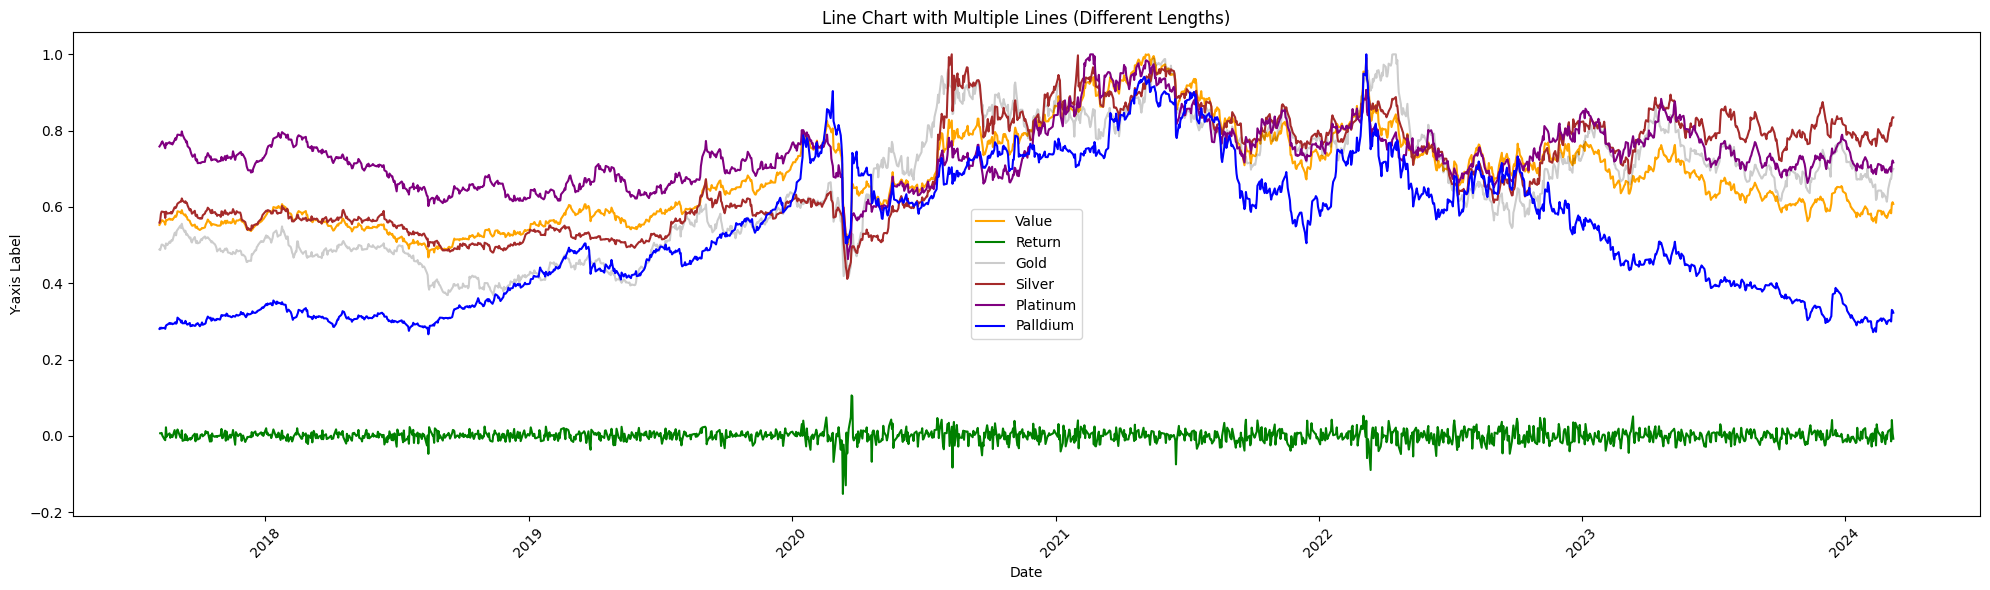

In [4]:
# Corresponding Y-axis values for two lines (different lengths)
y_gold = df['AU_PX_LAST']
y_silver = df['AG_PX_LAST']
y_platinum = df['PT_PX_LAST']
y_palldium = df['PD_PX_LAST']

total_value = df['Portfolio_Value']
by_day_return = df['Portfolio_Return']

# scale Y axis
y_gold_scaled = [val / max(y_gold) for val in y_gold]
y_silver_scaled = [val / max(y_silver) for val in y_silver]
y_pl_scaled = [val / max(y_platinum) for val in y_platinum]
y_pa_scaled = [val / max(y_palldium) for val in y_palldium]

value_scaled = [val /max(total_value) for val in total_value]

#TODO model total returns
#return_scaled = [val /max(by_day_return) for val in total_value]


plt.plot(df['Date'], value_scaled, label='Value', linestyle='-', color='orange')
plt.plot(df['Date'], df['Portfolio_Return'], label='Return', linestyle='-', color='green')

plt.plot(df['Date'], y_gold_scaled, label='Gold', linestyle='-',  alpha=0.2, color='black')
plt.plot(df['Date'], y_silver_scaled, label='Silver', linestyle='-', color='brown')
plt.plot(df['Date'], y_pl_scaled, label='Platinum', linestyle='-', color='purple')
plt.plot(df['Date'], y_pa_scaled, label='Palldium', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Y-axis Label')
plt.title('Line Chart with Multiple Lines (Different Lengths)')

# Format the date ticks on the X-axis for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()


Regime
H    561
L    546
M    545
Name: Regime, dtype: int64


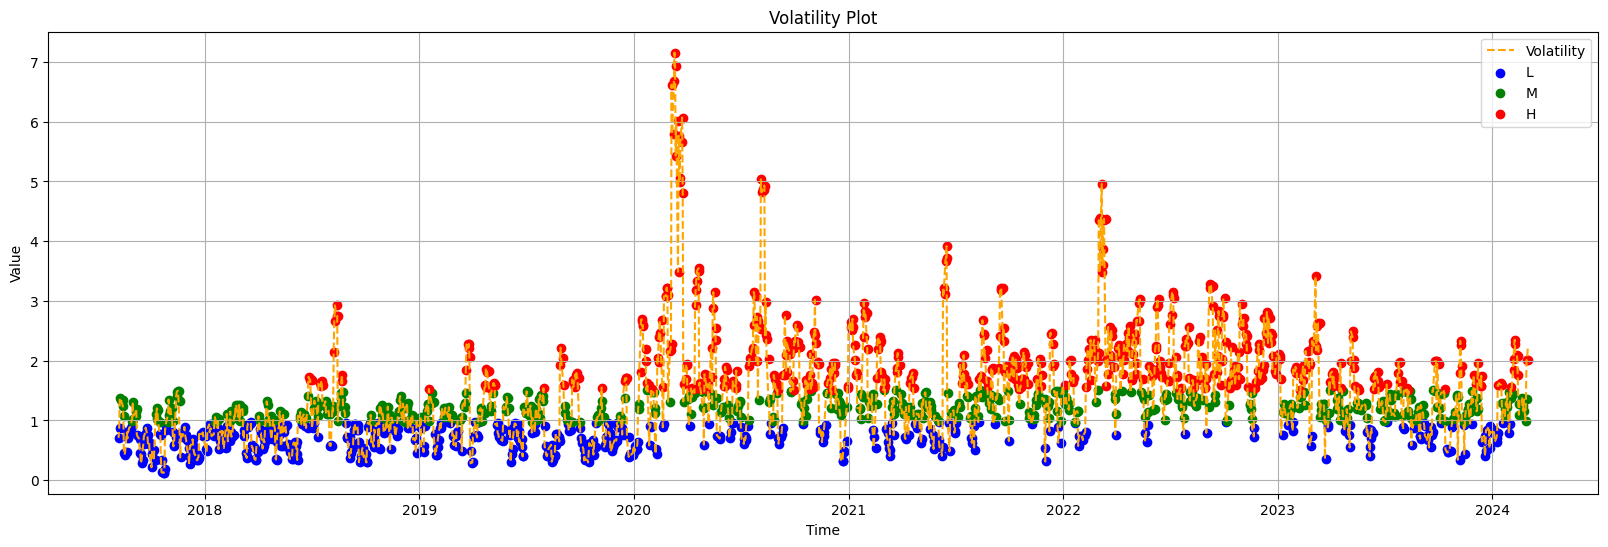

In [5]:
# calculate variance and volatility based on returns
# Define the rolling window size (e.g., 5 days)
window_size = 5

day_volatility = pd.Series(by_day_return).rolling(window=window_size).std().dropna() * 100
df = df.drop(df.index[:window_size])

# scale by 10o times
# Define thresholds for low, medium, and high volatility regimes
low_threshold = np.percentile(day_volatility, 33)
high_threshold = np.percentile(day_volatility, 66)

# Classify volatility into regimes based on thresholds
regime_labels = np.where(day_volatility < low_threshold, 'L',
                         np.where(day_volatility < high_threshold, 'M', 'H'))

# Create a DataFrame with volatility data and regime labels
df[['Volatility', 'Regime']] = pd.DataFrame({'Volatility': day_volatility, 'Regime': regime_labels})

sum_by_category = df.groupby('Regime')['Regime'].count()
print(sum_by_category)

# Plot the volatility
plt.plot(df['Date'], day_volatility, label='Volatility', linestyle='--', color='orange')

# plt.plot(df['Date'].drop(df.index[:window_size]), day_volatility, label='Volatility', linestyle='--', color='orange')
# Define colors for each regime label
colors = {'L': 'blue', 'M': 'green', 'H': 'red'}

# Plot volatility data with different colors for each regime label
for regime, color in colors.items():
    regime_data = df[df['Regime'] == regime]
    plt.scatter(regime_data['Date'], regime_data['Volatility'], color=color, label=regime)

plt.title('Volatility Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#### IF certain period has more low volatility points than high, it's low volatile

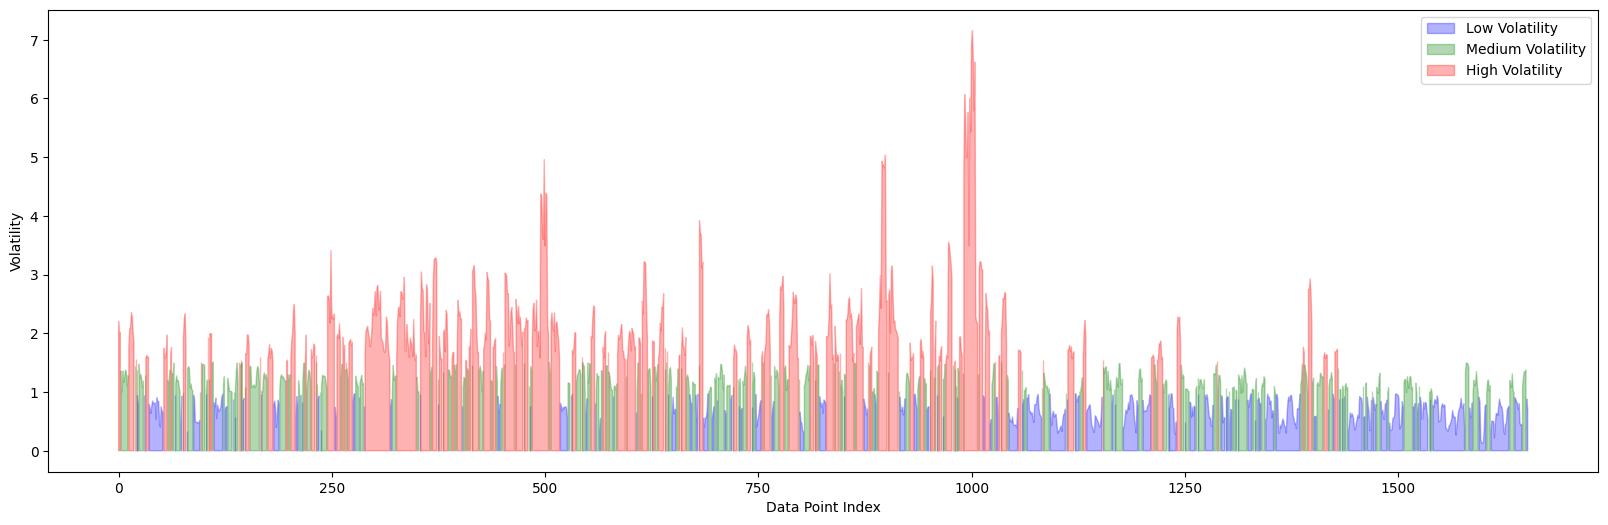

In [6]:
# Classify volatility into regimes based on thresholds
low_volatility = day_volatility < low_threshold
medium_volatility = (day_volatility >= low_threshold) & (day_volatility < high_threshold)
high_volatility = day_volatility >= high_threshold

# Plot the original volatility data
# plt.plot(volatility, color='black', label='Volatility')

# Shade areas for each volatility regime
plt.fill_between(range(len(day_volatility)), day_volatility.squeeze(), where=low_volatility.squeeze(), color='blue', alpha=0.3, label='Low Volatility')
plt.fill_between(range(len(day_volatility)), day_volatility.squeeze(), where=medium_volatility.squeeze(), color='green', alpha=0.3, label='Medium Volatility')
plt.fill_between(range(len(day_volatility)), day_volatility.squeeze(), where=high_volatility.squeeze(), color='red', alpha=0.3, label='High Volatility')

# Add labels and legend
plt.xlabel('Data Point Index')
plt.ylabel('Volatility')
plt.legend()


In [15]:
# Apply grouping to low/mid/high vol
df_vol = day_volatility.to_frame()

In [10]:
# normalize data
# df.drop(columns=['Date'], inplace=True)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
# numeric_columns.remove('Volatility')

# Calculate original means and standard deviations before normalization
original_means = df[numeric_columns].mean()
original_std_devs = df[numeric_columns].std()


normalized_data = (df[numeric_columns] - original_means) / original_std_devs
# first 4 and last 1 is na for volatility
normalized_data.fillna(0)

# normalized_data = normalized_data.drop('Volatility', axis=1)

#test_df = normalized_data[['UnixTs', 'Volatility']]


,AU_Return,AG_Return,PT_Return,PD_Return,AU_PX_LAST,AG_PX_LAST,PT_PX_LAST,PD_PX_LAST,AU_PX_OPEN,AU_PX_LOW,...,PT_INTRA_OC,PD_INTRA_OC,ICE Libor 1M PX_Last,ICE Libor 3M PX_Last,China Core CPI,US CPI Urban Consumer Index,UnixTs,Portfolio_Value,Portfolio_Return,Volatility
5,1.381875,1.110543,0.547299,0.496415,-0.050290,0.689188,-0.510835,-1.301495,-0.150830,-0.139053,...,0.519518,0.259321,1.923969,1.833530,-1.381928,1.815489,1.732290,-0.819133,0.763444,0.773962
6,1.049946,0.541799,0.000394,0.783273,-0.171737,0.579773,-0.587962,-1.321278,-0.187863,-0.143190,...,0.007293,0.445179,1.923867,1.834842,-1.381928,1.815489,1.730846,-0.879904,0.408283,0.776964
7,-0.641836,-0.022924,-0.753520,-0.450038,-0.261711,0.526569,-0.587576,-1.351978,-0.232301,-0.227064,...,-0.698849,-0.199946,1.925645,1.839068,-1.052513,1.815489,1.729403,-0.912161,-0.545370,-0.031535
8,-0.353827,-0.161742,0.739260,-0.790653,-0.208023,0.527595,-0.480139,-1.334525,-0.161570,-0.159739,...,0.700678,-0.380427,1.926023,1.840113,-1.052513,1.815489,1.727959,-0.869374,0.084991,-0.472501
9,-0.662360,-1.096324,-1.436206,-0.834730,-0.178402,0.541910,-0.584680,-1.303353,-0.176383,-0.165381,...,-1.316963,-0.403444,1.927298,1.837188,-1.052513,1.815489,1.726516,-0.876240,-1.318945,-0.033619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,-0.002350,-0.028954,0.203393,-0.225518,-0.959660,-0.777974,0.422991,-1.413359,-0.956281,-0.945450,...,0.231192,-0.098628,-0.451732,-0.505087,1.418098,-1.199473,-1.723691,-0.962394,0.043542,-0.047347
1654,0.665798,0.565625,0.389610,0.359237,-0.960030,-0.776752,0.391426,-1.405001,-0.970724,-0.936800,...,0.410439,0.170479,-0.450480,-0.508307,1.418098,-1.199473,-1.725135,-0.965916,0.464466,-0.008648
1655,0.614887,1.687198,0.227042,-0.354121,-1.005943,-0.818647,0.330806,-1.418475,-0.999609,-0.990961,...,0.236295,-0.154772,-0.450480,-0.508274,1.418098,-1.199473,-1.726578,-1.001918,0.384548,-0.620406
1656,-0.129633,0.615574,0.244052,0.429187,-1.047783,-0.939444,0.295862,-1.405334,-1.018866,-1.029701,...,0.257346,0.201456,-0.449537,-0.508126,1.418098,-1.199473,-1.728022,-1.031542,0.404758,-0.829636


In [11]:
# Windowing: Creating sequences/windows
sequence_length = 5  # which is the rolling window dates

def sequencing(dfrme):
    sequences = []
    size = len(dfrme)

    if (size == sequence_length):
        return np.array(dfrme)

    for i in range(size - sequence_length):
        sequences.append(dfrme[i:i+sequence_length])
    sequences = np.array(sequences)

    return sequences

sequences = sequencing(normalized_data)

In [16]:
sequences = sequencing(df_vol)

In [17]:
# Split data into train and validation sets
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
val_data = sequences[train_size:]

In [18]:
# Define the autoencoder model
num_features = 1

model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(num_features))
])

# custom_learning_rate = 0.00001  # Adjust this value as needed
# adam_optimizer = Adam(learning_rate=custom_learning_rate)

In [34]:
model.compile(optimizer='adam', loss='mse')

# Training the autoencoder
model.fit(train_data, train_data, epochs=200, batch_size=32, validation_data=(val_data, val_data))


Epoch 1/200
42/42 [==============================] - 5s 23ms/step - loss: 0.0753 - val_loss: 0.0108
Epoch 2/200
42/42 [==============================] - 0s 9ms/step - loss: 0.0253 - val_loss: 0.0089
Epoch 3/200
42/42 [==============================] - 0s 8ms/step - loss: 0.0237 - val_loss: 0.0088
Epoch 4/200
42/42 [==============================] - 0s 8ms/step - loss: 0.0235 - val_loss: 0.0082
Epoch 5/200
42/42 [==============================] - 0s 8ms/step - loss: 0.0232 - val_loss: 0.0092
Epoch 6/200
42/42 [==============================] - 0s 8ms/step - loss: 0.0228 - val_loss: 0.0097
Epoch 7/200
42/42 [==============================] - 0s 8ms/step - loss: 0.0267 - val_loss: 0.0205
Epoch 8/200
42/42 [==============================] - 0s 9ms/step - loss: 0.0331 - val_loss: 0.0087
Epoch 9/200
42/42 [==============================] - 0s 9ms/step - loss: 0.0246 - val_loss: 0.0089
Epoch 10/200
42/42 [==============================] - 0s 8ms/step - loss: 0.0236 - val_loss: 0.0125
Epoch 11

In [20]:
# predict today's regime
last_record = val_data[-1]
reshaped_data = np.expand_dims(last_record, axis=0).reshape((1,) + last_record.shape)
model.predict(reshaped_data)

array([[[1.1851764],
        [1.3185115],
        [1.3336   ],
        [1.1857107],
        [0.8811837]]], dtype=float32)

In [54]:
# Reconstruction of validation data
predicted_val_data = model.predict(val_data)
# predicted_val_data = np.squeeze(predicted_val_data, axis=-1)

# Calculating reconstruction loss
#reconstruction_losses = np.mean(np.square(val_data - predicted_val_data), axis=(1, 2))
reconstruction_losses = np.mean(np.square(val_data - predicted_val_data), axis=(1, ))

# MSE
mse = np.mean((val_data - predicted_val_data) ** 2)
rmse = np.sqrt(mse)

print(f"mse: {mse} \nrmse: {rmse}")


# Define a threshold for detecting regime changes
# Calculate mean and standard deviation of reconstruction errors on validation set
error_mean = np.mean(reconstruction_losses)
error_std = np.std(reconstruction_losses)

# Set threshold as a multiple of standard deviation above the mean error
#threshold = error_mean + 2 * error_std  # Adjust the multiplier as needed
# threshold = error_mean - error_std/24
threshold = error_mean * 0.95

print(f"error_mean {error_mean}\nerror_std {error_std}\nthreshold {threshold}")

# Detect regime changes based on the threshold for validation dataset
regime_change_indices_val = np.where(reconstruction_losses > threshold)[0]
regime_change_indices_val

# Calculate reconstruction errors for training data
predicted_train_data = model.predict(train_data)
# predicted_train_data = np.squeeze(predicted_train_data, axis=-1)

#reconstruction_errors_train = np.mean(np.square(train_data - predicted_train_data),  axis=(1, 2))
reconstruction_errors_train = np.mean(np.square(train_data - predicted_train_data), axis=(1, ))

regime_change_indices_train = np.where(reconstruction_errors_train > threshold)[0]

all_regime_change_indices = np.concatenate((regime_change_indices_train, regime_change_indices_val))

all_regime_change_indices

mse: 0.002740105144373143 
rmse: 0.052346013643573115
error_mean 0.0027401051443731433
error_std 0.0030187008923355193
threshold 0.002603099887154486


array([   2,    3,    4,    8,   17,   19,   21,   22,   23,   26,   28,
         34,   35,   42,   43,   47,   48,   50,   51,   57,   62,   63,
         64,   69,   70,   71,   72,   73,   75,   76,   77,   78,   79,
         80,   86,  101,  102,  103,  104,  108,  111,  112,  113,  114,
        123,  124,  125,  126,  132,  133,  134,  135,  137,  147,  163,
        164,  165,  166,  179,  181,  183,  185,  186,  204,  205,  206,
        208,  209,  213,  216,  217,  218,  220,  223,  233,  234,  235,
        236,  241,  242,  243,  245,  246,  247,  248,  249,  252,  253,
        254,  255,  259,  260,  261,  262,  275,  284,  285,  286,  287,
        294,  300,  301,  303,  307,  310,  318,  319,  320,  321,  323,
        331,  332,  333,  334,  335,  343,  344,  345,  346,  351,  352,
        353,  354,  358,  359,  361,  362,  363,  365,  366,  367,  368,
        369,  370,  371,  372,  373,  374,  376,  377,  380,  382,  383,
        385,  394,  395,  396,  398,  402,  410,  4

In [55]:
predict_portfolio = np.concatenate([predicted_train_data, predicted_val_data], axis=0)
# s = np.append(predict_portfolio, np.full(sequence_length, predict_portfolio[-1]))
# df_pred = df.assign(New_Column=s)

# # Get the shape of the NumPy array
# num_rows, temp, num_cols = predict_portfolio.shape

# Reshape the 3D array to 2D, dropping the middle dimension
reshaped_data = predict_portfolio.reshape(-1, predict_portfolio.shape[-1])

# Convert the 2D NumPy array to a DataFrame
df_pred = pd.DataFrame(reshaped_data)


In [37]:
denormalized_predictions = df_pred * original_std_devs + original_means
denormalized_predictions['Date'] = pd.to_datetime(denormalized_predictions['UnixTs'], unit='s')  # 's' for seconds, 'ms' for milliseconds

print(denormalized_predictions.head)

<bound method NDFrame.head of        0  AG_INTRA_HL  AG_INTRA_OC  AG_PX_HIGH  AG_PX_LAST  AG_PX_LOW  \
0    NaN          NaN          NaN         NaN         NaN        NaN   
1    NaN          NaN          NaN         NaN         NaN        NaN   
2    NaN          NaN          NaN         NaN         NaN        NaN   
3    NaN          NaN          NaN         NaN         NaN        NaN   
4    NaN          NaN          NaN         NaN         NaN        NaN   
...   ..          ...          ...         ...         ...        ...   
8235 NaN          NaN          NaN         NaN         NaN        NaN   
8236 NaN          NaN          NaN         NaN         NaN        NaN   
8237 NaN          NaN          NaN         NaN         NaN        NaN   
8238 NaN          NaN          NaN         NaN         NaN        NaN   
8239 NaN          NaN          NaN         NaN         NaN        NaN   

      AG_PX_OPEN  AG_Return  AU_INTRA_HL  AU_INTRA_OC  ...  PT_PX_LAST  \
0            NaN   

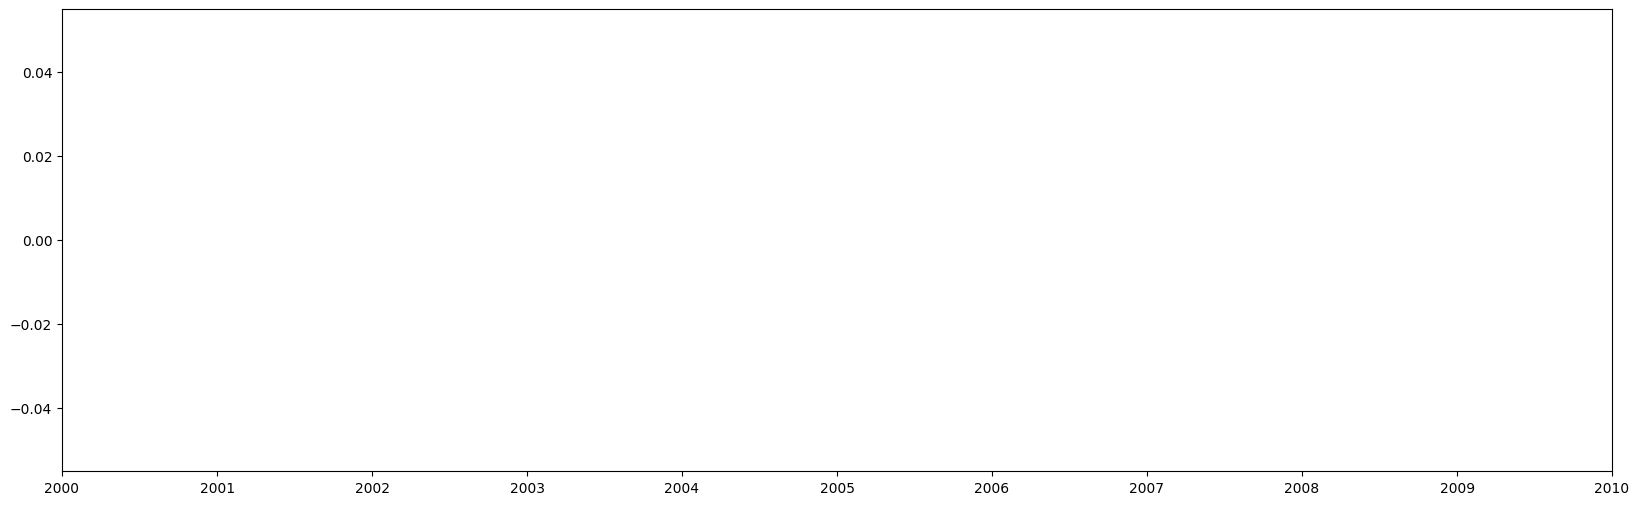

In [38]:
# Plot the data and change points
#plt.plot(df['Date'], df['Portfolio_Value'], label='Portfolio_Value', color="orange")
plt.plot(denormalized_predictions['Date'], denormalized_predictions['Portfolio_Value'], label='Portfolio_Value_Pred', color="gray")

In [60]:
# group change points
from sklearn.cluster import DBSCAN
# Reshape the data for DBSCAN (needed for sklearn)
X = all_regime_change_indices.reshape(-1, 1)

# DBSCAN parameters
epsilon = sequence_length * 4 # Maximum distance between points to be considered in the same neighborhood
min_samples = sequence_length * 2  # Minimum number of samples in a neighborhood

In [61]:
# DBSCAN clustering
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(X)

# Getting cluster labels and core sample indices
cluster_labels = dbscan.labels_
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

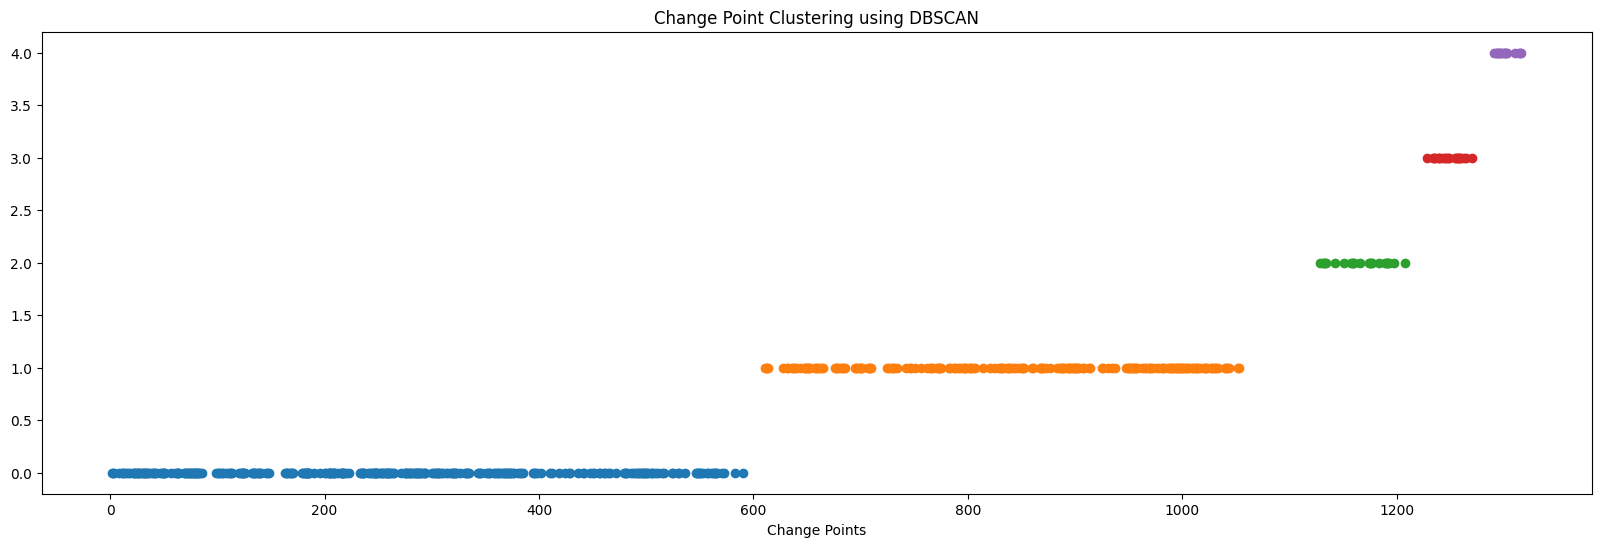

Cluster 0: Change Points - [array([  2,   3,   4,   8,  17,  19,  21,  22,  23,  26,  28,  34,  35,
        42,  43,  47,  48,  50,  51,  57,  62,  63,  64,  69,  70,  71,
        72,  73,  75,  76,  77,  78,  79,  80,  86, 101, 102, 103, 104,
       108, 111, 112, 113, 114, 123, 124, 125, 126, 132, 133, 134, 135,
       137, 147, 163, 164, 165, 166, 179, 181, 183, 185, 186, 204, 205,
       206, 208, 209, 213, 216, 217, 218, 220, 223, 233, 234, 235, 236,
       241, 242, 243, 245, 246, 247, 248, 249, 252, 253, 254, 255, 259,
       260, 261, 262, 275, 284, 285, 286, 287, 294, 300, 301, 303, 307,
       310, 318, 319, 320, 321, 323, 331, 332, 333, 334, 335, 343, 344,
       345, 346, 351, 352, 353, 354, 358, 359, 361, 362, 363, 365, 366,
       367, 368, 369, 370, 371, 372, 373, 374, 376, 377, 380, 382, 383,
       385, 394, 395, 396, 398, 402, 410, 412, 419, 424, 428, 429, 436,
       441, 442, 448, 450, 451, 456, 457, 461, 462, 464, 466, 472, 479,
       480, 481, 482, 486, 488, 490,

In [62]:
from collections import defaultdict

# Extracting unique clusters and their indices
unique_labels = set(cluster_labels)
cluster_change_points = defaultdict(list)

if -1 in unique_labels:
    unique_labels.remove(-1)  # Remove noise label (-1)


for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    cluster_change_points[label].append(cluster_points)
    plt.plot(cluster_points, np.ones_like(cluster_points) * label, 'o', label=f'Cluster {label}')

plt.xlabel('Change Points')
plt.title('Change Point Clustering using DBSCAN')
# plt.legend()
plt.show()

# Print or process cluster-wise change points
for cluster, points in cluster_change_points.items():
    print(f"Cluster {cluster}: Change Points - {points}")

In [67]:
# if a regime has more than 50% high volatility, then classify as high volatile regime
# similarly for medium and low volatility

# Dictionary to store regime classifications
regime_classifications = {}

# Calculate percentage of high volatility change points for each regime
for cluster, points in cluster_change_points.items():
    # Calculate the percentage of high volatility change points
    total_change_points = len(points[0])
    high_volatility_count = sum(df[change_point] == 'H' for change_point in points[0])
    high_volatility_percentage = high_volatility_count / total_change_points

    high_volatility_count = sum(df[change_point] == 'H' for change_point in points)
    high_volatility_percentage = high_volatility_count / total_change_points
    
    # Classify the regime based on the percentage
    # Classify the regime based on the percentage
    classification = 'High' if high_volatility_percentage >= 0.5 else \
                 'Medium' if high_volatility_percentage >= 0.5 else 'Low'

    
    # Store the classification for the regime
    regime_classifications[regime] = classification

# Print regime classifications
for regime, classification in regime_classifications.items():
    print(f"Regime {regime}: {classification} volatility")



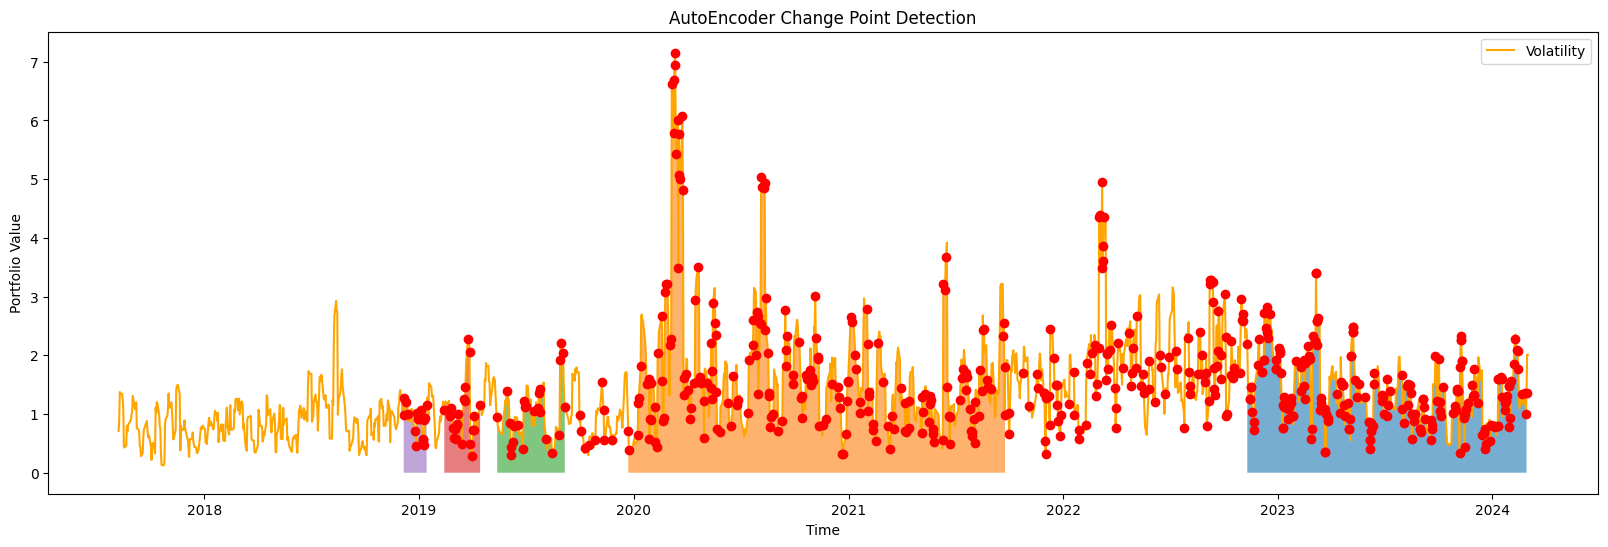

Change points detected at indices: [   2    3    4    8   17   19   21   22   23   26   28   34   35   42
   43   47   48   50   51   57   62   63   64   69   70   71   72   73
   75   76   77   78   79   80   86  101  102  103  104  108  111  112
  113  114  123  124  125  126  132  133  134  135  137  147  163  164
  165  166  179  181  183  185  186  204  205  206  208  209  213  216
  217  218  220  223  233  234  235  236  241  242  243  245  246  247
  248  249  252  253  254  255  259  260  261  262  275  284  285  286
  287  294  300  301  303  307  310  318  319  320  321  323  331  332
  333  334  335  343  344  345  346  351  352  353  354  358  359  361
  362  363  365  366  367  368  369  370  371  372  373  374  376  377
  380  382  383  385  394  395  396  398  402  410  412  419  424  428
  429  436  441  442  448  450  451  456  457  461  462  464  466  472
  479  480  481  482  486  488  490  491  492  493  495  496  497  498
  499  500  501  502  504  505  506  509  

In [63]:
# Plot the data and change points
# plt.plot(df['Date'], df['Portfolio_Value'], label='Portfolio_Value', color="orange")
plt.plot(df['Date'], df['Volatility'], label='Volatility', color="orange")


# Mark the change points on the chart
for change_point in all_regime_change_indices:
    plt.scatter(df['Date'].iloc[change_point], df['Volatility'].iloc[change_point], marker='o', color='red', zorder=3)

for cluster, points in cluster_change_points.items():
    # cluster_label = f"Cluster {cluster}"
    index_range = points[0]

    start_index = index_range[0]
    end_index = index_range[len(index_range) -1]

    plt.fill_between(df['Date'][start_index:end_index+1], df['Volatility'][start_index:end_index+1], alpha=0.6)

plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title('AutoEncoder Change Point Detection')
plt.legend()
plt.show()

print("Change points detected at indices:", all_regime_change_indices)

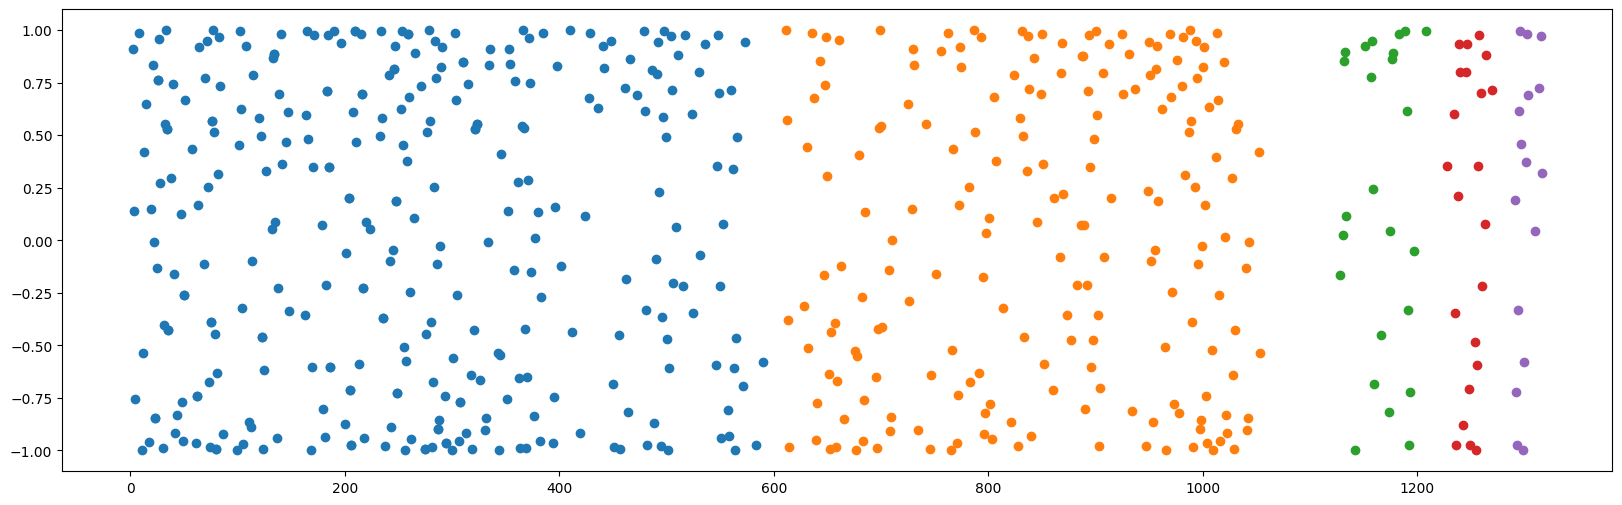

In [64]:
# Overlaying clustered change points on the original chart
for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    plt.plot(cluster_points, np.sin(cluster_points), 'o', label=f'Cluster {label}')


In [90]:
regimes = []

# Assuming 'data' is your DataFrame and 'all_regime_change_indices' contains change points
for i in range(len(all_regime_change_indices)):
    start_index = all_regime_change_indices[i]
    if i == len(all_regime_change_indices) - 1:
        end_index = len(df) - 1  # Use the last index of the data as the end index for the last regime
    else:
        end_index = all_regime_change_indices[i + 1]

    regime_window = df.iloc[start_index:end_index]
    regimes.append({
        'Regime': f'Regime_{i + 1}',
        'Start_Index': start_index,
        'End_Index': end_index,
        'Data': regime_window
    })

#regimes

In [91]:
# Gather recent 5 day's record
last_5_records = sequencing(normalized_data.tail(5))

# reshape
last_5_records_reshaped = np.expand_dims(last_5_records, axis=0)  # Add a batch dimension
# last_5_records_reshaped = np.expand_dims(last_5_records_reshaped, axis=1)  # Add a time step dimension


reconstructed_data = model.predict(last_5_records_reshaped)
reconstruction_error = np.mean(np.square(last_5_records_reshaped - reconstructed_data), axis=1)

if reconstruction_error > threshold:
    print("Regime change predicted for today!")
else:
    print("No regime change predicted for today.")
    # output current regime (low - medium - high volativlity)


ValueError: in user code:

    File "c:\Users\yangw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\yangw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yangw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\yangw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Users\yangw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\yangw\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_4" (type Sequential).
    
    Input 0 of layer "lstm_16" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 5, 35)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 5, 35), dtype=float32)
      • training=False
      • mask=None
